# Why Descend under the Spectral Norm?

In [68]:
import re

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sympy as sp

plt.rcParams["font.family"] = "monospace"

In [3]:
# Training parameters
NUM_DEVICES = 8
BATCH_PER_DEVICE = 1
SEQ_LEN = 64 * 1024
WINDOW_LEN = 1024
N_EMBD = 768
N_HEAD = 6
N_LAYERS = 12
N = N_EMBD / N_HEAD

NUM_ITERATIONS = 1825
VAL_LOSS_EVERY = 125

In [4]:
IMAGES_SAVE_PATH = "."
ATT_NORMS_PATTERN = r"fro_norm = ([0-9.]+) \| spectral_norm = ([0-9.]+)"
WEIGHT_NAME_PATTERN = r"transformer\.h\.([0-9]+)\.attn\.(c_q|c_k)\.weight"

## Prepare data

### Load

In [5]:
filenames = [
    "14091bb9-d75e-482e-a5f9-f32ef1c17ae6.txt",
    "22a49b2a-84c6-4522-a68b-02f3ae7107dc.txt",
]

labels = [
    "Muon",
    "Adam",
]

files = [open(filename, "r").readlines() for filename in filenames]

### Preprocess data

In [10]:
# layers: list[list[int]] = [[] for _ in range(len(files))]
# weight_names: list[list[str]] = [[] for _ in range(len(files))]
matrix_norms: list[list[list[float]]] = [[] for _ in range(len(files))]
for idx, file in enumerate(files):
    for line in file:
        if "module._orig_mod." not in line:
            continue
        # layer_weight = re.search(WEIGHT_NAME_PATTERN, line)
        # layers[idx].append(int(layer_weight.group(1)))
        # weight_names[idx].append(layer_weight.group(2))
        norms = re.search(ATT_NORMS_PATTERN, line)
        matrix_norms[idx].append(list(map(lambda x: float(x), norms.groups())))

# layers = np.array(layers)
# weight_names = np.array(weight_names)
# [num_files, num_evals, layers, num_weights, num_norms]
matrix_norms: np.ndarray = np.array(matrix_norms).reshape(
    -1, (NUM_ITERATIONS // VAL_LOSS_EVERY) + 2, N_LAYERS, 2, 2
)

## Analysis

### The "sharpness" of attention logits

**Definition: sharpness.** Let $e^{(n)} \in \mathbb{R}^n$ be a collection of $n$ logits, computed using a dot-product attention mechanism; i.e., $e^{(n)}_k = <Qy, Kx_k>,$ where $y \in \mathbb{R}^d$ is a query vector and $Q, K \in \mathbb{R}^{m' \times m}$ are query and key matrices, respectively. The "sharpness", $\delta$, of this collection of logits is defined as the difference between the maximum and the minimum of the logits. Formally, $$\delta = \max_{1\leq i \leq n}(e^{(n)}_i) - \min_{1\leq j \leq n}(e^{(n)}_j).$$

Following simple linear algebra, we can upper bound this as: $$\delta \leq 2\cdot\|Q\|_S\cdot\|K\|_S\cdot\|y\|\cdot\max_{i\leq i\leq n}\|x_i\|$$

Now, in our implementation, we use QK-normalization and MultiHead Attention (MHA). Thus, $\|y\| \approx \|x_i\| \approx \frac{1}{\sqrt{N_{EMBD} / N_{HEAD}}}$ where $N_{EMBD}$ is the embedding dimension and $N_{HEAD}$ is the number of heads in the MHA. Thus, $$\delta \leq \frac{2}{N_{EMBD} / N_{HEAD}}\cdot\|Q\|_S\cdot\|K\|_S\cdot$$

Definition & bound taken from the paper [softmax is not enough (for sharp out-of-distribution)](https://arxiv.org/abs/2410.01104).

In [11]:
max_sharpness = (
    (2 / (N_EMBD / N_HEAD))
    * matrix_norms[:,:,:,0,1]  # spec(Q)
    * matrix_norms[:,:,:,1,1]  # spec(K)
)

### The maximum and minimum entropy of attention coefficients for a given $\delta$

Maximum entropy is achieved when all logits are equal. If we set $N$ to be the number of input tokens, then we simply have $H_{max} = log(N)$.

To get the minimum entropy, we assume that one of the logits attains the maximum value while the rest attains the minimum. First, let's calculate the probability of the maximum logit:
$$p_1 = \frac{e^{l_{max}}}{e^{l_{max}} + (N-1)e^{l_{min}}} = \frac{1}{1 + (N-1)e^{-\delta}} = \frac{1}{D}$$
where $q = e^{-\delta}$ and $D = 1 + (N-1)q$. Thus, the probability of the other $N-1$ logits that attain the minimum value then is:
$$p_i = \frac{q}{D}, \quad i \geq 2$$

The entropy can then be calculated as:
$$H_{min} = -\Sigma_{i = 1}^{N} [p_i \log{p_i}]$$
$$H_{min} = -(\frac{1}{D}\log{\frac{1}{D}} + (N-1)\frac{q}{D}\log{\frac{q}{D}})$$
$$H_{min} = \log{D} - (N-1)\frac{q}{D}\log{q}$$

#### Entropy calculation



In [87]:
def calc_min_entropy_from_sharpness_(sharpness):
    # One logit attains maximum value, all others attain minimum value
    q = sp.exp(-sharpness)
    D = 1 + (WINDOW_LEN - 1) * q
    H_min = sp.log(D) - (WINDOW_LEN - 1) * (q / D) * sp.log(q)
    return H_min


calc_min_entropy_from_sharpness = sp.lambdify(sp.symbols("sharpness"), calc_min_entropy_from_sharpness_(sp.symbols("sharpness")), "numpy")

In [88]:
# Maximum entropy: all logits attain the same value
H_max = np.log(WINDOW_LEN)
# Minimum entropy: one logit attains maximum value, all others attain minimum value
H_min = calc_min_entropy_from_sharpness(max_sharpness)

## Plots

In [90]:
labels = ["Muon", "Adam"]

color_palettes = [
    sns.color_palette("Blues", max_sharpness.shape[1]),
    sns.color_palette("Reds", max_sharpness.shape[1]),
]

Text(0.5, 1.0, 'Minimum Entropy & Sharpness Over QK Spectral Norms\n($N_{EMBD}/N_{HEAD}=128$)')

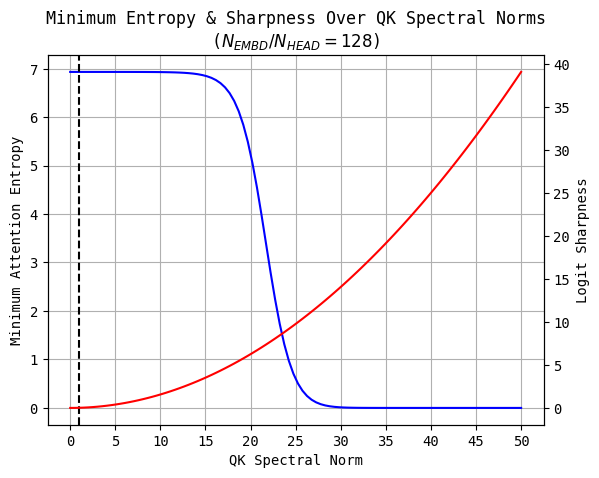

In [117]:
init_spec_norm = np.linspace(0, 50, 100)
init_sharpness = (2 / (N_EMBD / N_HEAD)) * init_spec_norm**2
init_min_entropy = calc_min_entropy_from_sharpness(init_sharpness)

fig, ax1 = plt.subplots()

ax1.set_xlabel("QK Spectral Norm")
ax1.set_xticks(np.linspace(0, 50, 11))

# left y-axis
sns.lineplot(x=init_spec_norm, y=init_min_entropy, ax=ax1, color="blue")
ax1.set_ylabel("Minimum Attention Entropy")
ax1.grid(True)
plt.axvline(x=1, color="black", linestyle="--")
# right y-axis
ax2 = ax1.twinx()
sns.lineplot(x=init_spec_norm, y=init_sharpness, ax=ax2, color="red")
ax2.set_ylabel("Logit Sharpness")

plt.title("Minimum Entropy & Sharpness Over QK Spectral Norms\n($N_{EMBD}/N_{HEAD}=128$)")

### Spectral Norm of Q and K

In [ ]:
Q_spectral_norms = matrix_norms[:,:,:,0,1]

for i in range(Q_spectral_norms.shape[0]):
    for j in range(Q_spectral_norms.shape[1]):
        label = None if j != Q_spectral_norms.shape[1] - 1 else labels[i]
        sns.lineplot(Q_spectral_norms[i][j], color=color_palettes[i][j], label=label)

plt.text(3, 20, "Darker = More Training Steps")

plt.xticks(np.linspace(0, 11, 12))
plt.ylim(0, 40)
plt.xlabel("Layer")
plt.ylabel("Query Spectral Norm")
plt.title("Dynamics of Query Spectral Norms During Training")
# text on legend
plt.legend(title="Optimizer")
plt.tight_layout()
plt.savefig(f"{IMAGES_SAVE_PATH}/attention_Q_spectral_norms.png")

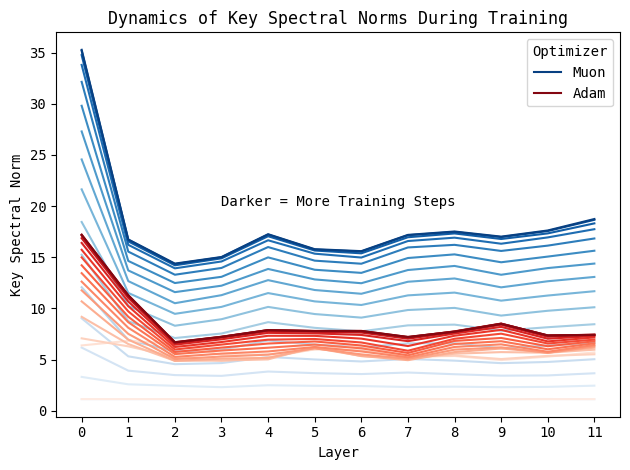

In [118]:
K_spectral_norms = matrix_norms[:,:,:,1,1]

for i in range(K_spectral_norms.shape[0]):
    for j in range(K_spectral_norms.shape[1]):
        label = None if j != K_spectral_norms.shape[1] - 1 else labels[i]
        sns.lineplot(K_spectral_norms[i][j], color=color_palettes[i][j], label=label)

plt.text(3, 20, "Darker = More Training Steps")

plt.xticks(np.linspace(0, 11, 12))
plt.xlabel("Layer")
plt.ylabel("Key Spectral Norm")
plt.title("Dynamics of Key Spectral Norms During Training")
# text on legend
plt.legend(title="Optimizer")
plt.tight_layout()
plt.savefig(f"{IMAGES_SAVE_PATH}/attention_K_spectral_norms.png")

### Sharpness

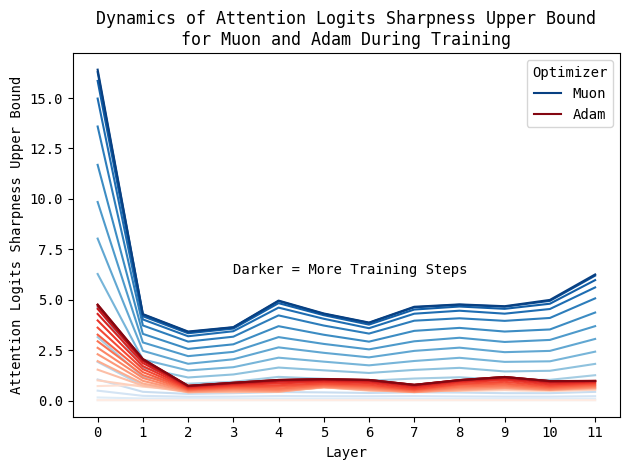

In [94]:
for i in range(max_sharpness.shape[0]):
    for j in range(max_sharpness.shape[1]):
        label = None if j != max_sharpness.shape[1] - 1 else labels[i]
        sns.lineplot(max_sharpness[i][j], color=color_palettes[i][j], label=label)

plt.text(3, 6.3, "Darker = More Training Steps")

plt.xticks(np.linspace(0, 11, 12))
plt.xlabel("Layer")
plt.ylabel("Attention Logits Sharpness Upper Bound")
plt.title("Dynamics of Attention Logits Sharpness Upper Bound\nfor Muon and Adam During Training")
# text on legend
plt.legend(title="Optimizer")
plt.tight_layout()
plt.savefig(f"{IMAGES_SAVE_PATH}/attention_sharpness_dynamics.png")

### Attention Entropy

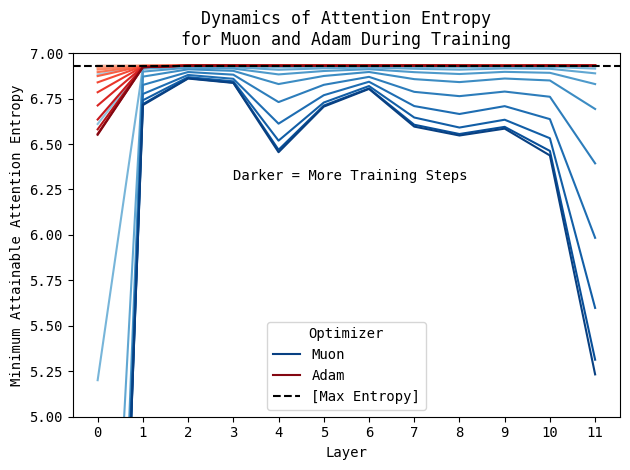

In [95]:
for i in range(H_min.shape[0]):
    for j in range(H_min.shape[1]):
        label = None if j != H_min.shape[1] - 1 else labels[i]
        sns.lineplot(H_min[i][j], color=color_palettes[i][j], label=label)

plt.text(3, 6.3, "Darker = More Training Steps")
plt.axhline(H_max, color="black", linestyle="--", label="[Max Entropy]")

plt.ylim(bottom=5, top=7)
plt.xticks(np.linspace(0, 11, 12))
plt.xlabel("Layer")
plt.ylabel("Minimum Attainable Attention Entropy")
plt.title("Dynamics of Attention Entropy\nfor Muon and Adam During Training")
plt.legend(title="Optimizer")
plt.tight_layout()
plt.savefig(f"{IMAGES_SAVE_PATH}/attention_entropy_dynamics.png")

### Sympy

In [110]:
qk_spec_norm_ = sp.symbols("x")
att_logit_sharpness_ = (2 / (N_EMBD / N_HEAD)) * qk_spec_norm_ ** 2
att_min_entropy_ = calc_min_entropy_from_sharpness_(att_logit_sharpness_)
diff_att_min_entropy_ = sp.diff(att_min_entropy_, qk_spec_norm_)
diff_att_min_entropy_np = sp.lambdify(qk_spec_norm_, diff_att_min_entropy_, "numpy")

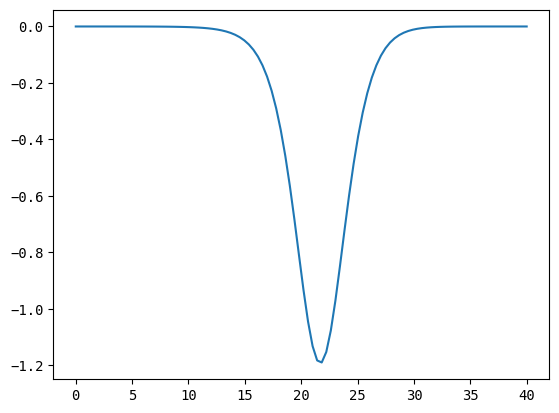

In [111]:
x = np.linspace(0, 40, 100)
y = diff_att_min_entropy_np(x)
plt.plot(x, y)